# Neural Machine Translation

Translating human-readable dates to standard machine-readable dates using attention mechanisms.

_PyTorch implementation of the assignment of Course 5 of Coursera's Deep Learning Specialization_.

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from babel.dates import format_date
from faker import Faker
from torch.utils.data import DataLoader, Dataset

## Reproducibility

In [2]:
seed = 24
Faker.seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed);

## Device Configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataset

We will create a custom dataset that will provide the following:

- Each sample is a human-readable date, represented as an array of one-hot encoded indices where each index comes from a vocabulary padded to a length of $T_x=30$
- Each corresponding target is a machine-readable date, represented as an array of indices where each index comes from a vocabulary of length $T_y=10$ (the form YYYY-MM-DD)
- 10,000 training examples

We will also generate the following dictionaries:

- `human_to_idx`: mapping all characters used in the human-readable dates to indices including two special characters: `<UNK>` and `<PAD>`
- `machine_to_idx`: mapping all characters used in machine-readable dates to indices
- `idx_to_machine`: mapping from indices back to machine-readable characters

In [4]:
# Generate fake dates as training examples
# Code taken from the Deep Learning Specialization assignment
formats = ['short', 'medium', 'long', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'd MMM YYY', 'd MMMM YYY',
           'dd MMM YYY', 'd MMM, YYY', 'd MMMM, YYY', 'dd, MMM YYY', 'd MM YY', 'd MMMM YYY', 'MMMM d YYY', 'MMMM d, YYY', 'dd.MM.YY']

fake = Faker()

def create_date():
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(formats),  locale='en_US')
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',', '')
        machine_readable = dt.isoformat()
    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable

human_vocab = set()
machine_vocab = set()
dataset = []
    

for i in range(10000):
    h, m = create_date()

    if h is not None:
        dataset.append((h, m))
        human_vocab.update(tuple(h))
        machine_vocab.update(tuple(m))

    human_to_idx = dict(zip(sorted(human_vocab) + ['<UNK>', '<PAD>'], list(range(len(human_vocab) + 2))))
    idx_to_machine = dict(enumerate(sorted(machine_vocab)))
    machine_to_idx = {v:k for k, v in idx_to_machine.items()}

Let's look at some raw samples before any other preprocessing is applied.

In [5]:
dataset[:10]

[('june 23 2018', '2018-06-23'),
 ('sunday january 21 1996', '1996-01-21'),
 ('29 aug 2009', '2009-08-29'),
 ('saturday june 5 1982', '1982-06-05'),
 ('thursday november 8 1984', '1984-11-08'),
 ('friday may 22 1981', '1981-05-22'),
 ('friday march 18 1983', '1983-03-18'),
 ('saturday july 11 1981', '1981-07-11'),
 ('august 27 2015', '2015-08-27'),
 ('may 21 2016', '2016-05-21')]

In [6]:
def to_indices(date, length, vocab):
    # Taken from the Deep Learning Specialization assignment
    date = date.lower().replace(',', '')

    # Truncate
    if len(date) > length:
        date = date[:length]

    # Convert to array of indices
    date = list(map(lambda x: vocab.get(x, '<UNK>'), date))

    # Pad
    if len(date) < length:
        date += [vocab['<PAD>']] * (length - len(date))

    return date

def collate_fn(batch):
    # We define a custom collate_fn so that we can do the following:
    # - Convert human and machine dates into indices, padding/tuncating to Tx=30 and Ty=10, respectively
    # - One-hot encode the human dates
    human_dates, machine_dates = zip(*batch)

    # Compute the original lengths which will be useful for packing the padded sequence
    lengths = [len(d) for d in human_dates]
    # Convert to indices, padding or truncating to Tx=30
    human_dates = torch.tensor([to_indices(d, 30, human_to_idx) for d in human_dates])
    # One-hot encode
    human_dates = F.one_hot(human_dates, num_classes=len(human_to_idx)).float()

    # Convert machine dates to indices
    machine_dates = torch.tensor([to_indices(d, 10, machine_to_idx) for d in machine_dates]).long()

    return human_dates, machine_dates, lengths


class DatesDataset(Dataset):
    def __init__(self):
        self.X, self.y = zip(*dataset)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = self.X[idx]
        y = self.y[idx]

        return X, y

We can now create the training set. We use the same batch size (100) as in the Deep Learning Specialization assignment.

In [7]:
training = DataLoader(DatesDataset(), batch_size=100, shuffle=True, num_workers=4, collate_fn=collate_fn)

## Model

We'll use a **sequence-to-sequence** model with an attention mechanism as follows:

- A pre-attention Bidirectional LSTM with 32 hidden units that takes in the one-hot encoded human-dates
- A post-attention LSTM with 64 hidden units that takes in a context vector computed by an attention mechanism
- An output layer, with softmax activation, over the vocabulary of the machine-readable dates

Note that because our model uses a Bidirectional LSTM the whole input sequence $T_x$ is processed at once. As opposed to processing each timestep $t$ at a time.

![](img/model.png)

### Attention Mechanism

The attention mechanism is computed as follows:

- A fully-connected layer with 10 units and tanh activation that takes in all hidden states of the pre-attention Bidirectional LSTM and the previous hidden state of the post-attention LSTM
- A second fully-connected layer with 1 unit and ReLU activation
- A softmax activation over the previous output

![](img/attn_mechanism.png)

In [8]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()

        # Input shape (batch_size, 2 * 32 + 64) where
        # - 2 * 32 comes from the activations of pre-attention Bidirectional LSTM
        # - 64 comes from the previous hidden state of the post-attention LSTM
        self.fc1 = nn.Sequential(nn.Linear(in_features=2 * 32 + 64, out_features=10), nn.Tanh())
        self.fc2 = nn.Sequential(nn.Linear(in_features=10, out_features=1), nn.ReLU(inplace=True))

    def forward(self, a, s):
        # Repeat the previous hidden state of the post-attention LSTM over all timesteps
        # The shape will go from (batch_size, 64) to (batch_size, Tx=30, 64)
        s = s.unsqueeze(1).repeat(1, 30, 1)
        # Concatenate with the activations of the pre-attention Bidirectional LSTM
        concatenated = torch.cat([a, s], axis=-1)
        # Pass it through the two Fully-Connected layers and compute the weights using softmax over all timesteps
        # The shape is (batch_size, Tx=30, 1) so we use dim=1 to apply softmax over the Tx dimension
        weights = F.softmax(self.fc2(self.fc1(concatenated)), dim=1)
        # Compute the context vector as a weight sum
        # We permute the axes of the weights to go from (batch_size, seq_len, 1) to (batch_size, 1, seq_len) to correctly compute the dot product
        # We also squeeze dim=1 of the context vector to go from (batch_size, 1, 64) to (batch_size, 64)
        context = torch.matmul(weights.permute(0, 2, 1), a).squeeze(1)

        return context


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # The first LSTM layer expects sequences of size of the length of the human vocab
        self.pre_lstm = nn.LSTM(input_size=len(human_to_idx), hidden_size=32, bidirectional=True, batch_first=True)
        self.attn = Attention()
        # The second LSTM layer takes in the context vector (a weight per each activation of the Bidirectional LSTM)
        # We use `LSTMCell` since we will explicitly loop through each timestep of the output (Ty)
        self.post_lstm = nn.LSTMCell(input_size=2 * 32, hidden_size=64)
        # Output layer to convert to target space (length of the machine vocab)
        self.out = nn.Linear(in_features=64, out_features=len(machine_to_idx))
        # We don't define a softmax output layer explicitly because it's combined with the loss function

    def forward(self, input, lengths):
        # Pack the padded sequence so that the layers ignore the padded values during backprop
        # See: https://ryankresse.com/dealing-with-pad-tokens-in-sequence-models-loss-masking-and-pytorchs-packed-sequence/
        packed = nn.utils.rnn.pack_padded_sequence(input, lengths, batch_first=True, enforce_sorted=False)
        # Pass through Bidirectional LSTM to process the full sequence
        hiddens, state = self.pre_lstm(packed)
        # Since we passed in a packed sequence, we need to "unpack" it
        # We need to make sure that the unpacking operation respects our initial desired max length of Tx=30 though!
        # See: https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e
        a, _= torch.nn.utils.rnn.pad_packed_sequence(hiddens, batch_first=True, padding_value=human_to_idx['<PAD>'], total_length=30)
        # Initialize the hidden and cell states of the post-attention LSTM with shape (batch_size, hidden_size=64)
        s = torch.zeros(input.shape[0], 64).float().to(input.device)
        c = torch.zeros(input.shape[0], 64).float().to(input.device)
        # Holds all the outputs for all timesteps of the output sequence (Ty) of shape (batch_size, Ty=10, len(machine_vocab))
        outputs = torch.zeros(input.shape[0], 10, len(machine_to_idx)).to(input.device)

        # Generate each output one by one since the attention mechanism requires the previous hidden state from the post-attention LSTM at each step
        for i in range(10):
            # Pass through attention mechanism to generate the context vector
            context = self.attn(a, s)
            # Pass through post-attention LSTM
            s, c = self.post_lstm(context, (s, c))
            # Convert to target space
            output = self.out(s)
            outputs[:, i, :] = output

        return outputs

In [9]:
model = Model()
print(model)

Model(
  (pre_lstm): LSTM(37, 32, batch_first=True, bidirectional=True)
  (attn): Attention(
    (fc1): Sequential(
      (0): Linear(in_features=128, out_features=10, bias=True)
      (1): Tanh()
    )
    (fc2): Sequential(
      (0): Linear(in_features=10, out_features=1, bias=True)
      (1): ReLU(inplace=True)
    )
  )
  (post_lstm): LSTMCell(64, 64)
  (out): Linear(in_features=64, out_features=11, bias=True)
)


## Optimization

We'll use Adam for training the model with the cross-entropy loss. We'll use the same learning rate as in the Deep Learning Specialization assignment.

In [10]:
loss_fn =  nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

## Training

Time to train the model!

In [11]:
# Training configuration
epochs = 35

[0/35]	Loss: 2.1164774894714355
[1/35]	Loss: 2.0184097290039062
[2/35]	Loss: 1.4495065212249756
[3/35]	Loss: 0.8534033894538879
[4/35]	Loss: 0.7653688192367554
[5/35]	Loss: 0.5815529823303223
[6/35]	Loss: 0.442037969827652
[7/35]	Loss: 0.30376631021499634
[8/35]	Loss: 0.18202467262744904
[9/35]	Loss: 0.10328581929206848
[10/35]	Loss: 0.056844159960746765
[11/35]	Loss: 0.032530777156353
[12/35]	Loss: 0.02193582057952881
[13/35]	Loss: 0.016952818259596825
[14/35]	Loss: 0.013270527124404907
[15/35]	Loss: 0.010394573211669922
[16/35]	Loss: 0.008912596851587296
[17/35]	Loss: 0.007201767060905695
[18/35]	Loss: 0.005956578999757767
[19/35]	Loss: 0.00629280973225832
[20/35]	Loss: 0.0047896746546030045
[21/35]	Loss: 0.004013095051050186
[22/35]	Loss: 0.004252012353390455
[23/35]	Loss: 0.004102514591068029
[24/35]	Loss: 0.003191363764926791
[25/35]	Loss: 0.002497264416888356
[26/35]	Loss: 0.002083725295960903
[27/35]	Loss: 0.002214329782873392
[28/35]	Loss: 0.0018872880609706044
[29/35]	Loss: 0.

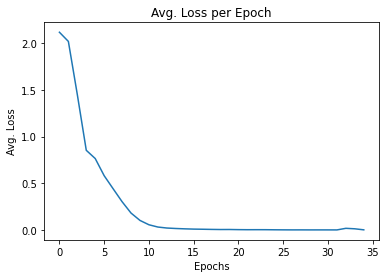

In [12]:
# Main training loop
model = model.to(device)
total_losses = []

for epoch in range(epochs):
    losses = []

    for samples, targets, lengths in training:
        optimizer.zero_grad()

        samples = samples.to(device)
        targets = targets.to(device)

        output = model(samples, lengths)

        # Reshape the outputs and targets to (batch_size * seq_len, len(machine_vocab)) so the loss can be computed
        output = output.view(-1, len(machine_to_idx))
        targets = targets.flatten()
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        
        # Detach the loss to avoid saving any more computations on it
        losses.append(loss.detach().cpu().numpy())

    total_losses.append(np.mean(losses))
    print(f'[{epoch}/{epochs}]\tLoss: {total_losses[-1]}')

# Save the model
torch.save(model.state_dict(), 'model/model.pt')

# Plot the losses
plt.plot(np.squeeze(total_losses))
plt.ylabel('Avg. Loss')
plt.xlabel('Epochs')
plt.title('Avg. Loss per Epoch')
plt.show()

## Testing

Now that we have trained our model, we can try it with the same examples from the Deep Learning Specialization assignment

In [13]:
# Load the trained model
model = Model()
model.load_state_dict(torch.load('model/model.pt'))
# Always set the mode to `eval` for inference
model.eval()
model = model.to(device)

examples = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001',
            '1 March 2001']

for example in examples:
    # Preprocess like we did for the training samples
    lengths = [len(example)]
    human = torch.tensor(to_indices(example, 30, human_to_idx))
    human = F.one_hot(human, num_classes=len(human_to_idx)).float()
    # Add the batch_size=1 dimension
    human = human.unsqueeze(0)

    # Predict and grab the most likely index for each timestep of the output sequence
    preds = model(human.to(device), lengths).squeeze(0)
    preds = F.softmax(preds, dim=-1)
    preds = preds.detach().cpu().numpy()
    preds = np.argmax(preds, axis=-1)

    # Convert back to a machine-readable date
    machine = [idx_to_machine[int(i)] for i in preds]

    print(f'Human: {example}')
    print(f'Machine: {"".join(machine)}')
    print()

Human: 3 May 1979
Machine: 1979-05-03

Human: 5 April 09
Machine: 2009-04-05

Human: 21th of August 2016
Machine: 2016-08-02

Human: Tue 10 Jul 2007
Machine: 2007-07-10

Human: Saturday May 9 2018
Machine: 2018-05-09

Human: March 3 2001
Machine: 2001-03-03

Human: March 3rd 2001
Machine: 2001-03-03

Human: 1 March 2001
Machine: 2001-03-01



Even with a small amount of epochs, the model is able to learn quite well how to translate dates from very different human-readable formats!